# Required Capstone Component 14.1


## New Information

From my one-on-one, I have the following tips:
- Look at the distance between my new point and the closest old point
- my understanding of what to set $\kappa$ to to balance exploitation and exploration was incorrect, so I was setting $\kappa$ too low, prioritising exploitation much more. So for this week, I will choose much higher values for $\kappa$ to better balance the two, maybe even leaning more towards exploration. 
- $\kappa = 1$ will balance exploration and exploitation (https://ekamperi.github.io/machine%20learning/2021/06/11/acquisition-functions.html)

## Import Data

In [ ]:
# Import any necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C, Matern
from scipy.stats import norm
from statistics import mean
import itertools
import math
import ast
from scipy.spatial.distance import pdist, squareform


# load initial inputs
x_1 = np.load("updated_data/week_13/function_1/inputs_week_13.npy")
x_2 = np.load("updated_data/week_13/function_2/inputs_week_13.npy")
x_3 = np.load("updated_data/week_13/function_3/inputs_week_13.npy")
x_4 = np.load("updated_data/week_13/function_4/inputs_week_13.npy")
x_5 = np.load("updated_data/week_13/function_5/inputs_week_13.npy")
x_6 = np.load("updated_data/week_13/function_6/inputs_week_13.npy")
x_7 = np.load("updated_data/week_13/function_7/inputs_week_13.npy")
x_8 = np.load("updated_data/week_13/function_8/inputs_week_13.npy")

# load initial outputs
y_1 = np.load("updated_data/week_13/function_1/outputs_week_13.npy")
y_2 = np.load("updated_data/week_13/function_2/outputs_week_13.npy")
y_3 = np.load("updated_data/week_13/function_3/outputs_week_13.npy")
y_4 = np.load("updated_data/week_13/function_4/outputs_week_13.npy")
y_5 = np.load("updated_data/week_13/function_5/outputs_week_13.npy")
y_6 = np.load("updated_data/week_13/function_6/outputs_week_13.npy")
y_7 = np.load("updated_data/week_13/function_7/outputs_week_13.npy")
y_8 = np.load("updated_data/week_13/function_8/outputs_week_13.npy")


In [20]:
x_new = [np.array([0.313131, 0.080808]), 
np.array([0.787879, 0.939394]), 
np.array([0.323232, 0.282828, 0.454545]), 
np.array([0.346939, 0.408163, 0.469388, 0.428571]), 
np.array([0.22449 , 0.857143, 0.897959, 0.877551]), 
np.array([0.482759, 0.344828, 0.551724, 0.655172, 0.137931]), 
np.array([0.      , 0.5     , 0.285714, 0.142857, 0.357143, 0.714286]), 
np.array([0.  , 0.25, 0.  , 0.25, 0.75, 0.5 , 0.  , 0.75])]


y_new = [np.float64(-2.9364314294151675e-90), 
np.float64(0.007709089202919565), 
np.float64(-0.033998513053481755), 
np.float64(-0.45051458077022444), 
np.float64(1223.3527601803028), 
np.float64(-0.24386899752868774), 
np.float64(1.330462993084332), 
np.float64(9.8258)]


print(x_new)
print(y_new)

print(type(x_new))
print(type(y_new))

print(x_new[2]) 
print(y_new[2])








[array([0.313131, 0.080808]), array([0.787879, 0.939394]), array([0.323232, 0.282828, 0.454545]), array([0.346939, 0.408163, 0.469388, 0.428571]), array([0.22449 , 0.857143, 0.897959, 0.877551]), array([0.482759, 0.344828, 0.551724, 0.655172, 0.137931]), array([0.      , 0.5     , 0.285714, 0.142857, 0.357143, 0.714286]), array([0.  , 0.25, 0.  , 0.25, 0.75, 0.5 , 0.  , 0.75])]
[np.float64(-2.9364314294151675e-90), np.float64(0.007709089202919565), np.float64(-0.033998513053481755), np.float64(-0.45051458077022444), np.float64(1223.3527601803028), np.float64(-0.24386899752868774), np.float64(1.330462993084332), np.float64(9.8258)]
<class 'list'>
<class 'list'>
[0.323232 0.282828 0.454545]
-0.033998513053481755


## Create Functions


In [80]:
def find_closest_neighbor_distances(points):
    """
    Find the distance from each point to its closest neighbor.
    
    Args:
        points: numpy array of shape (n_points, n_dimensions)
    
    Returns:
        distances: array of distances to closest neighbor for each point
    """
    # Compute pairwise distances
    distances_matrix = squareform(pdist(points))
    
    # Set diagonal to infinity to exclude self-distances
    np.fill_diagonal(distances_matrix, np.inf)
    
    # Find minimum distance for each point (closest neighbor)
    closest_distances = np.min(distances_matrix, axis=1)
    
    return closest_distances



def find_min_distance_to_array(single_point, array_of_points):
    """
    Find the minimum distance from a single point to an array of points.
    
    Args:
        single_point: numpy array of shape (n_dimensions,)
        array_of_points: numpy array of shape (n_points, n_dimensions)
    
    Returns:
        min_distance: scalar, minimum distance
        closest_index: index of the closest point
    """
    # Calculate distances from single point to all points in array
    distances = np.sqrt(np.sum((array_of_points - single_point)**2, axis=1))
    
    # Find minimum distance and its index
    min_distance = np.min(distances)
    closest_index = np.argmin(distances)
    
    return min_distance, closest_index




def plot_boxplot_with_new_point(data, new_data, title="Boxplot with New Point", 
                                ylabel="nearest neighbor distance",
                               new_point_label=None, figsize=(10, 6)):
    """
    Create a boxplot with a new point overlaid in red.
    
    Parameters:
    -----------
    data : array-like
        The data to create the boxplot from
    new_data : float
        The new point value to overlay
    title : str, optional
        Title for the plot (default: "Boxplot with New Point")
    ylabel : str, optional
        Label for y-axis (default: "nearest neighbor distance")
    new_point_label : str, optional
        Custom label for the new point (default: auto-generated)
    figsize : tuple, optional
        Figure size (default: (10, 6))
    
    Returns:
    --------
    fig, ax : matplotlib figure and axes objects
    """
    
    # Create figure
    plt.figure(figsize=figsize)
    
    # Create the boxplot
    box_plot = plt.boxplot(data, patch_artist=True)
    
    # Style the boxplot
    box_plot['boxes'][0].set_facecolor('lightblue')
    box_plot['boxes'][0].set_alpha(0.7)
    
    # Convert new_data to float if it's numpy type
    new_value = float(new_data)
    
    # Generate label if not provided
    if new_point_label is None:
        new_point_label = f'New point: {new_value:.6e}'
    
    # Add the new point in red
    plt.scatter(1, new_value, color='red', s=100, zorder=5, label=new_point_label)
    
    # Add value label for the new point
    plt.annotate(f'{new_value:.6e}', 
                xy=(1, new_value), 
                xytext=(1.1, new_value),
                arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
                fontsize=10, 
                color='red',
                ha='left')
    
    # Customize the plot
    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel(ylabel, fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    
    # Show the plot
    plt.show()





def plot_boxplot(data, 
                title="Boxplot with New Point", 
                ylabel="nearest neighbor distance",
                figsize=(10, 6)):
    """
    Create a boxplot with a new point overlaid in red.
    
    Parameters:
    -----------
    data : array-like
        The data to create the boxplot from
    title : str, optional
        Title for the plot (default: "Boxplot with New Point")
    ylabel : str, optional
        Label for y-axis (default: "nearest neighbor distance")
    figsize : tuple, optional
        Figure size (default: (10, 6))
    
    Returns:
    --------
    fig, ax : matplotlib figure and axes objects
    """
    plt.figure(figsize=figsize)
    plt.boxplot(data, vert=True, patch_artist=True, 
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2),
                whiskerprops=dict(color='black', linewidth=1.5),
                capprops=dict(color='black', linewidth=1.5),
                flierprops=dict(marker='o', markerfacecolor='red', markersize=4, alpha=0.6))
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()

## Compare Old Values to New

### Function 1

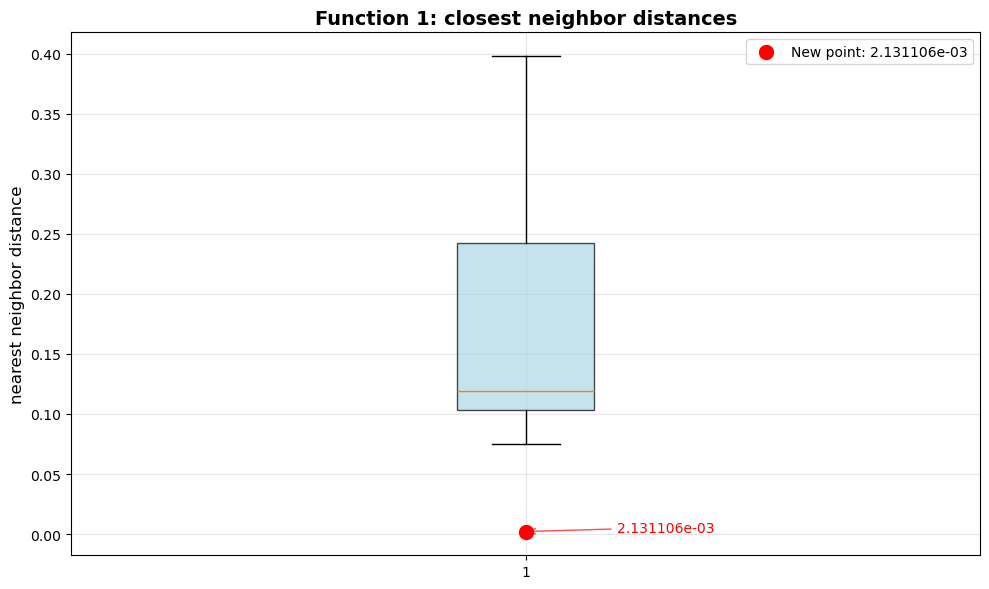

In [64]:
x1_distances = find_closest_neighbor_distances(np.array(x_1))
new_x1_distance = find_min_distance_to_array(x_new[0], np.array(x_1))
plot_boxplot_with_new_point(
    x1_distances, 
    new_x1_distance[0], 
    'Function 1: closest neighbor distances', 
    'nearest neighbor distance')

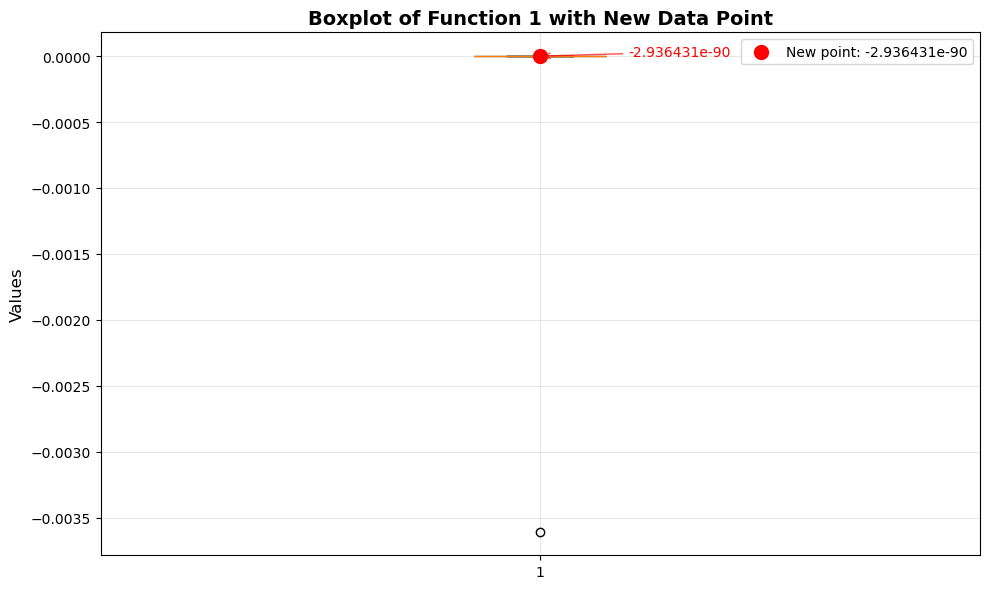

Old maximum: 7.710875e-16
New point: -2.936431e-90
Percentile rank in y_1: 18.2%

Old position: [0.73102363 0.73299988]
New position: [0.313131 0.080808]


In [65]:

plot_boxplot_with_new_point(
    y_1, 
    y_new[0], 
    'Boxplot of Function 1 with New Data Point', 
    'Values')

# Print some statistics for comparison
print(f"Old maximum: {np.max(y_1):.6e}")
print(f"New point: {y_new[0]:.6e}")
print(f"Percentile rank in y_1: {100 * (y_1 < y_new[0]).sum() / len(y_1):.1f}%")
print(f"\nOld position: {x_1[np.argmax(y_1)]}")
print(f"New position: {x_new[0]}")

### Function 2

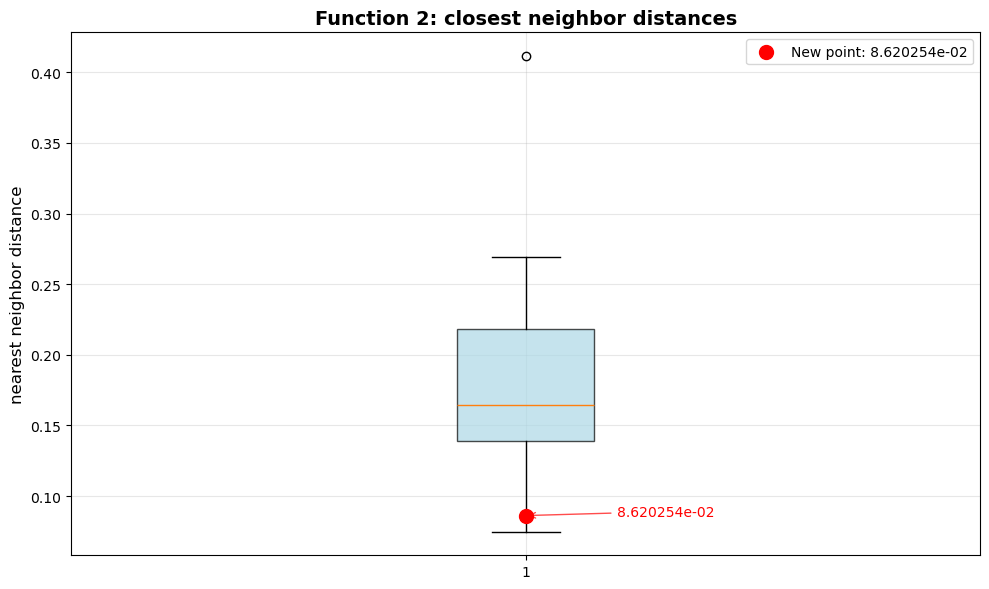

In [66]:
x2_distances = find_closest_neighbor_distances(np.array(x_2))
new_x2_distance = find_min_distance_to_array(x_new[1], np.array(x_2))
plot_boxplot_with_new_point(
    x2_distances, 
    new_x2_distance[0], 
    'Function 2: closest neighbor distances', 
    'nearest neighbor distance')

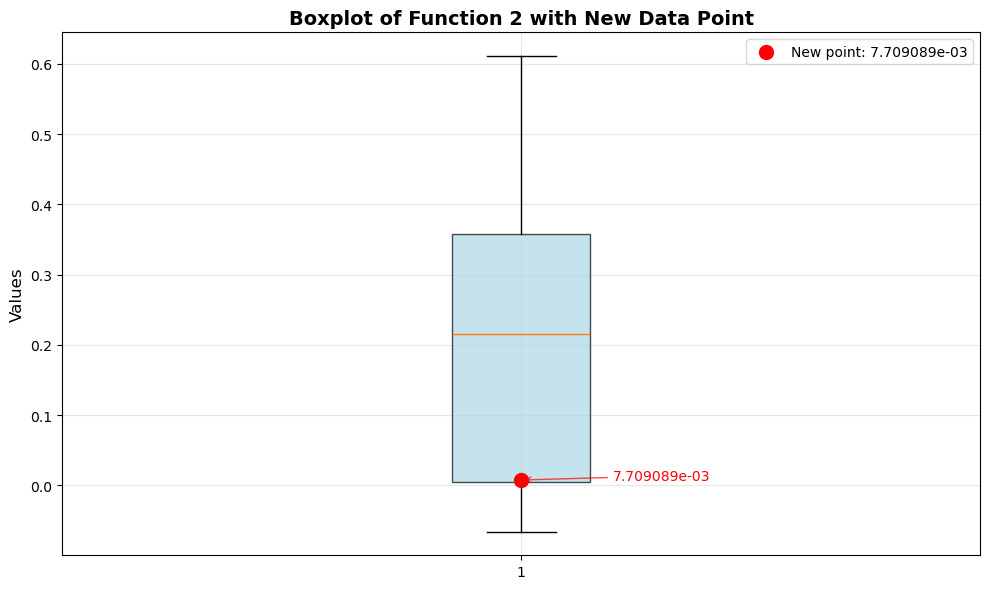

Old maximum: 6.112052e-01
New point: 7.709089e-03
Percentile rank in y_2: 27.3%

Old position: [0.70263656 0.9265642 ]
New position: [0.787879 0.939394]


In [73]:

plot_boxplot_with_new_point(
    y_2, 
    y_new[1], 
    'Boxplot of Function 2 with New Data Point', 
    'Values')

# Print some statistics for comparison
print(f"Old maximum: {np.max(y_2):.6e}")
print(f"New point: {y_new[1]:.6e}")
print(f"Percentile rank in y_2: {100 * (y_2 < y_new[1]).sum() / len(y_2):.1f}%")
print(f"\nOld position: {x_2[np.argmax(y_2)]}")
print(f"New position: {x_new[1]}")

### Function 3

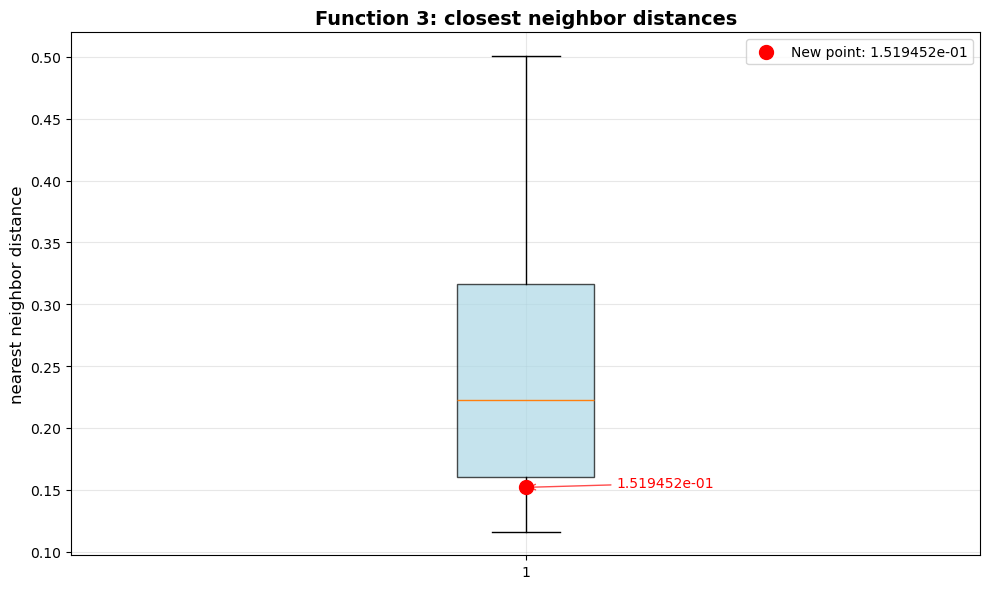

In [67]:
x3_distances = find_closest_neighbor_distances(np.array(x_3))
new_x3_distance = find_min_distance_to_array(x_new[2], np.array(x_3))
plot_boxplot_with_new_point(
    x3_distances, 
    new_x3_distance[0], 
    'Function 3: closest neighbor distances', 
    'nearest neighbor distance')

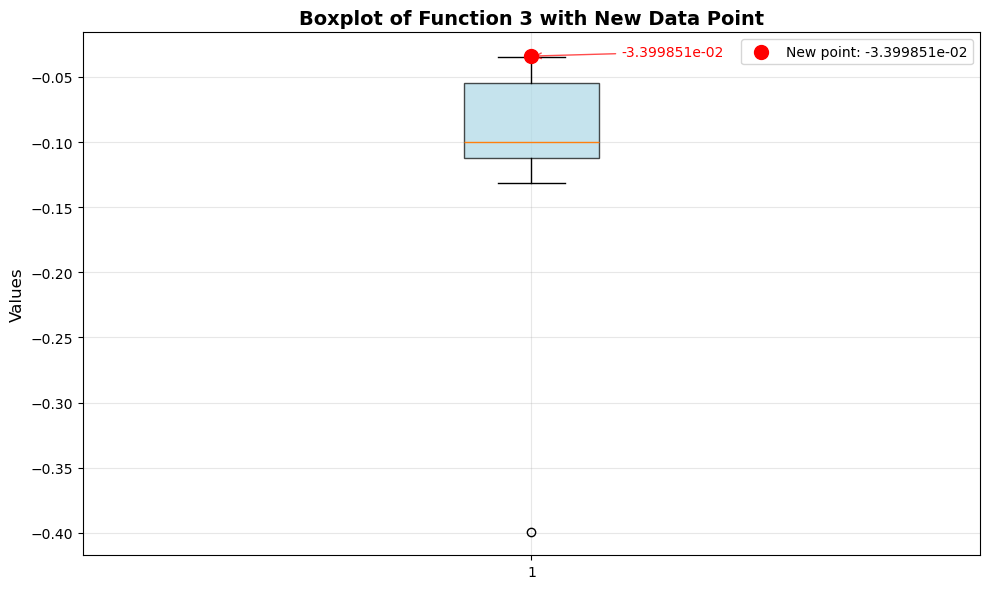

Old maximum: -3.483531e-02
New point: -3.399851e-02
Percentile rank in y_3: 100.0%

Old position: [0.49258141 0.61159319 0.34017639]
New position: [0.323232 0.282828 0.454545]


In [74]:

plot_boxplot_with_new_point(
    y_3, 
    y_new[2], 
    'Boxplot of Function 3 with New Data Point', 
    'Values')

# Print some statistics for comparison
print(f"Old maximum: {np.max(y_3):.6e}")
print(f"New point: {y_new[2]:.6e}")
print(f"Percentile rank in y_3: {100 * (y_3 < y_new[2]).sum() / len(y_3):.1f}%")
print(f"\nOld position: {x_3[np.argmax(y_3)]}")
print(f"New position: {x_new[2]}")

### Function 4

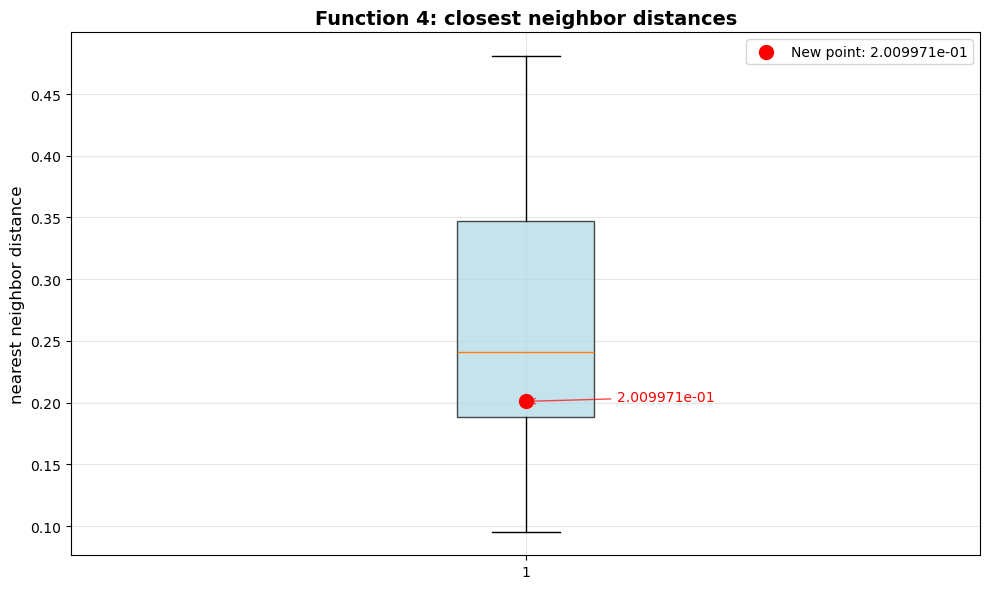

In [68]:
x4_distances = find_closest_neighbor_distances(np.array(x_4))
new_x4_distance = find_min_distance_to_array(x_new[3], np.array(x_4))
plot_boxplot_with_new_point(
    x4_distances, 
    new_x4_distance[0], 
    'Function 4: closest neighbor distances', 
    'nearest neighbor distance')

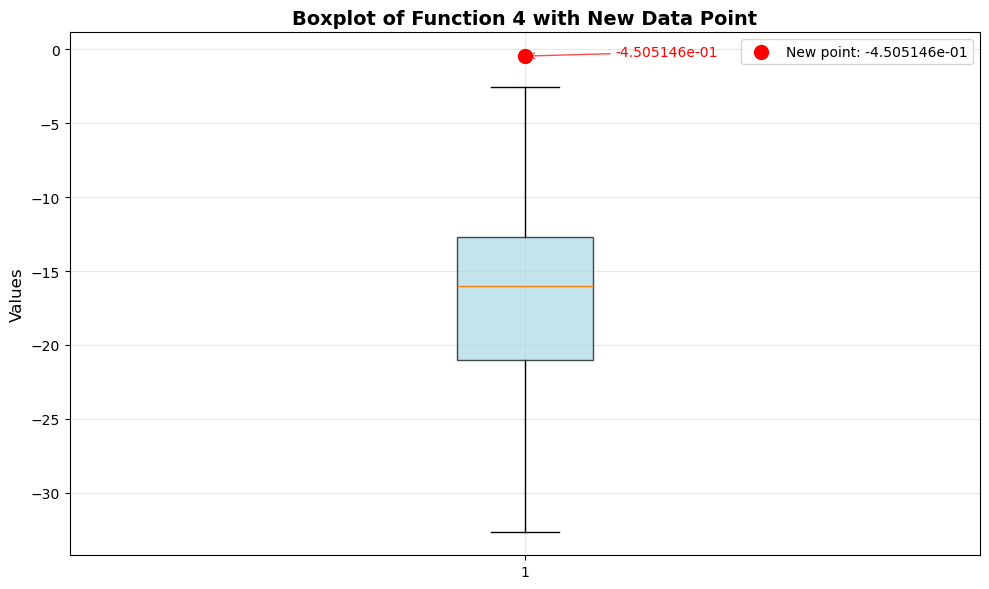

Old maximum: -2.547194e+00
New point: -4.505146e-01
Percentile rank in y_4: 100.0%

Old position: [0.510204 0.489796 0.387755 0.408163]
New position: [0.346939 0.408163 0.469388 0.428571]


In [75]:

plot_boxplot_with_new_point(
    y_4, 
    y_new[3], 
    'Boxplot of Function 4 with New Data Point', 
    'Values')

# Print some statistics for comparison
print(f"Old maximum: {np.max(y_4):.6e}")
print(f"New point: {y_new[3]:.6e}")
print(f"Percentile rank in y_4: {100 * (y_4 < y_new[3]).sum() / len(y_4):.1f}%")
print(f"\nOld position: {x_4[np.argmax(y_4)]}")
print(f"New position: {x_new[3]}")

### Function 5

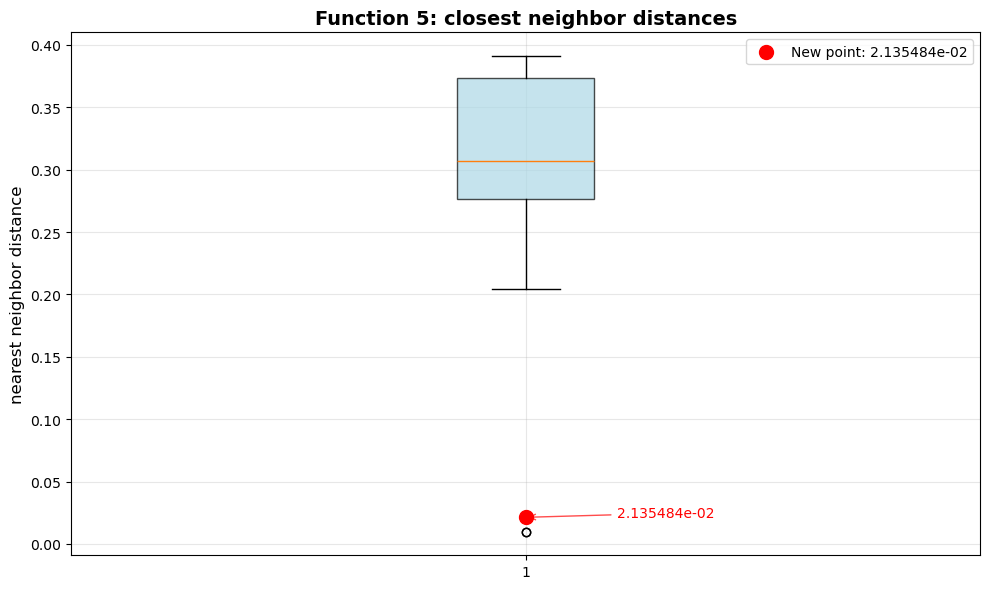

In [69]:
x5_distances = find_closest_neighbor_distances(np.array(x_5))
new_x5_distance = find_min_distance_to_array(x_new[4], np.array(x_5))
plot_boxplot_with_new_point(
    x5_distances, 
    new_x5_distance[0], 
    'Function 5: closest neighbor distances', 
    'nearest neighbor distance')

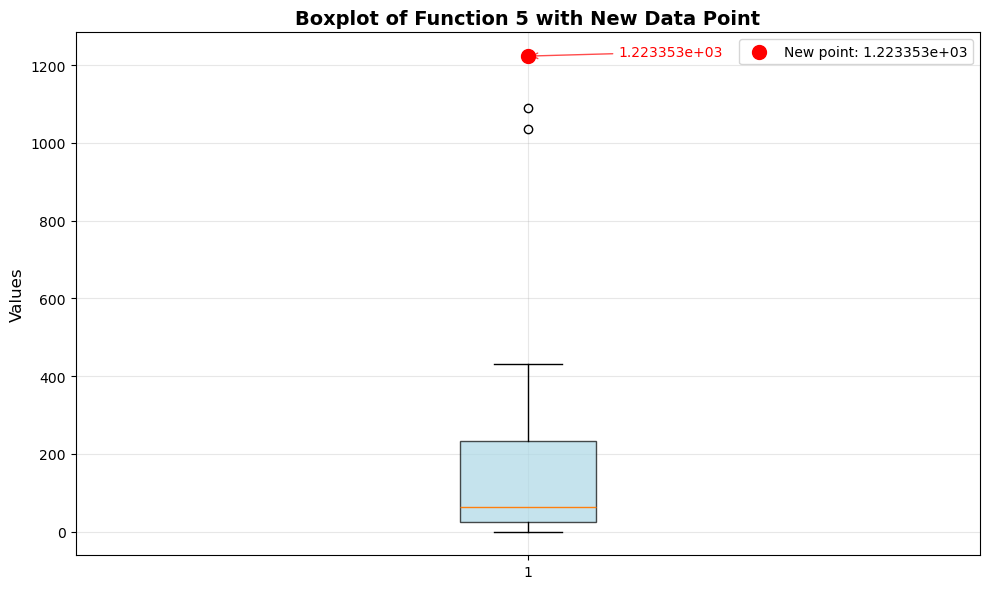

Old maximum: 1.088860e+03
New point: 1.223353e+03
Percentile rank in y_5: 100.0%

Old position: [0.22418902 0.84648049 0.87948418 0.87851568]
New position: [0.22449  0.857143 0.897959 0.877551]


In [76]:

plot_boxplot_with_new_point(
    y_5, 
    y_new[4], 
    'Boxplot of Function 5 with New Data Point', 
    'Values')

# Print some statistics for comparison
print(f"Old maximum: {np.max(y_5):.6e}")
print(f"New point: {y_new[4]:.6e}")
print(f"Percentile rank in y_5: {100 * (y_5 < y_new[4]).sum() / len(y_5):.1f}%")
print(f"\nOld position: {x_5[np.argmax(y_5)]}")
print(f"New position: {x_new[4]}")

### Function 6

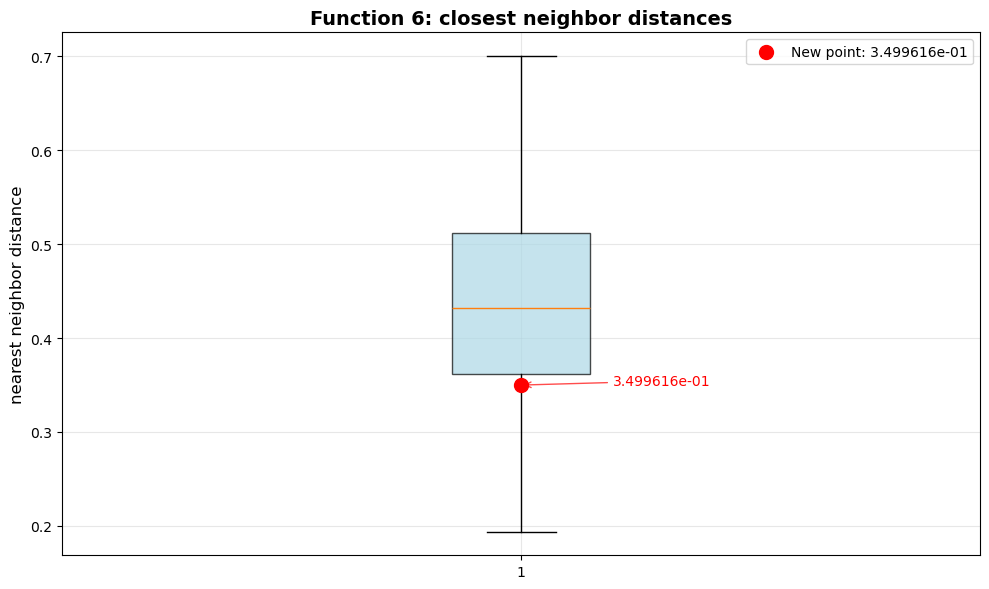

In [70]:
x6_distances = find_closest_neighbor_distances(np.array(x_6))
new_x6_distance = find_min_distance_to_array(x_new[5], np.array(x_6))
plot_boxplot_with_new_point(
    x6_distances, 
    new_x6_distance[0], 
    'Function 6: closest neighbor distances', 
    'nearest neighbor distance')

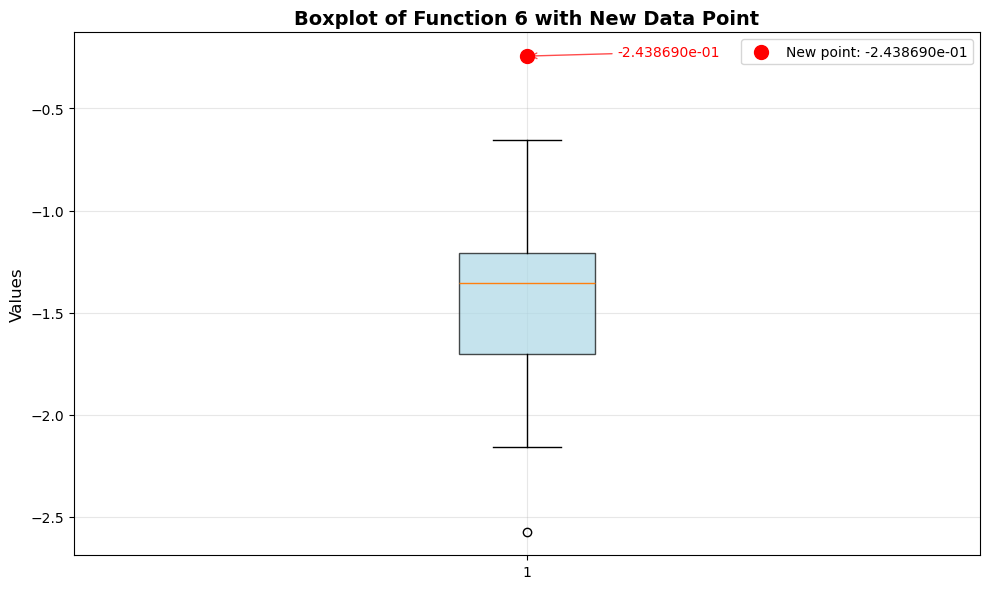

Old maximum: -6.533581e-01
New point: -2.438690e-01
Percentile rank in y_6: 100.0%

Old position: [0.517241 0.413793 0.275862 0.827586 0.241379]
New position: [0.482759 0.344828 0.551724 0.655172 0.137931]


In [77]:

plot_boxplot_with_new_point(
    y_6, 
    y_new[5], 
    'Boxplot of Function 6 with New Data Point', 
    'Values')

# Print some statistics for comparison
print(f"Old maximum: {np.max(y_6):.6e}")
print(f"New point: {y_new[5]:.6e}")
print(f"Percentile rank in y_6: {100 * (y_6 < y_new[5]).sum() / len(y_6):.1f}%")
print(f"\nOld position: {x_6[np.argmax(y_6)]}")
print(f"New position: {x_new[5]}")

### Function 7

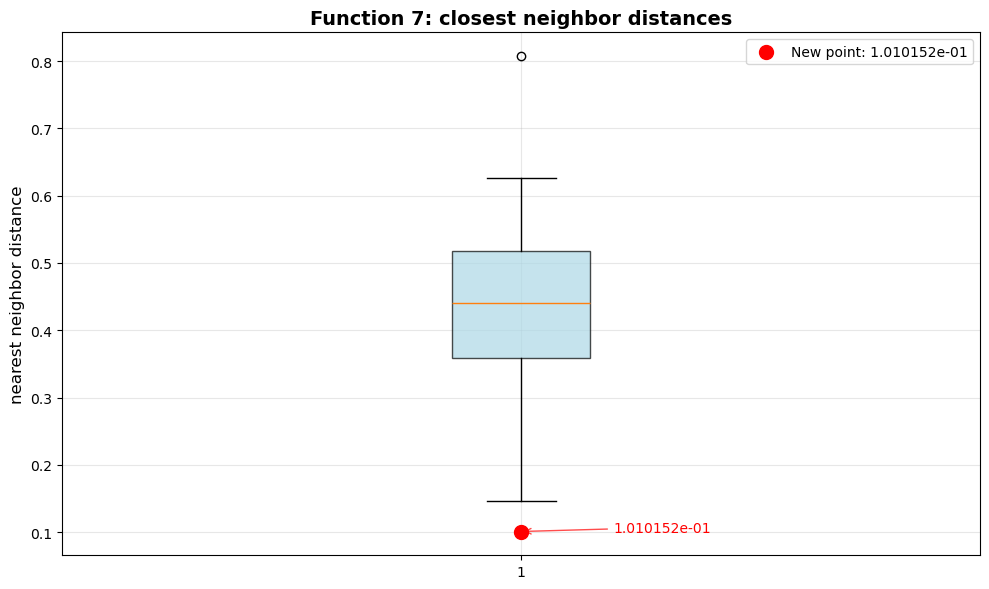

In [71]:
x7_distances = find_closest_neighbor_distances(np.array(x_7))
new_x7_distance = find_min_distance_to_array(x_new[6], np.array(x_7))
plot_boxplot_with_new_point(
    x7_distances, 
    new_x7_distance[0], 
    'Function 7: closest neighbor distances', 
    'nearest neighbor distance')

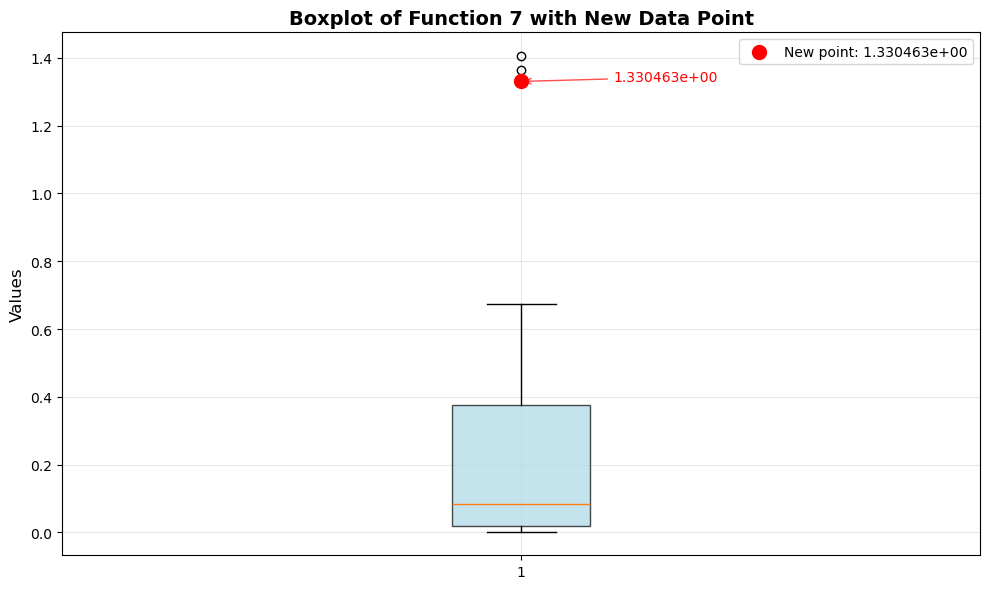

Old maximum: 1.405168e+00
New point: 1.330463e+00
Percentile rank in y_7: 93.5%

Old position: [0.       0.428571 0.285714 0.142857 0.357143 0.785714]
New position: [0.       0.5      0.285714 0.142857 0.357143 0.714286]


In [78]:

plot_boxplot_with_new_point(
    y_7, 
    y_new[6], 
    'Boxplot of Function 7 with New Data Point', 
    'Values')

# Print some statistics for comparison
print(f"Old maximum: {np.max(y_7):.6e}")
print(f"New point: {y_new[6]:.6e}")
print(f"Percentile rank in y_7: {100 * (y_7 < y_new[6]).sum() / len(y_7):.1f}%")
print(f"\nOld position: {x_7[np.argmax(y_7)]}")
print(f"New position: {x_new[6]}")

### Function 8

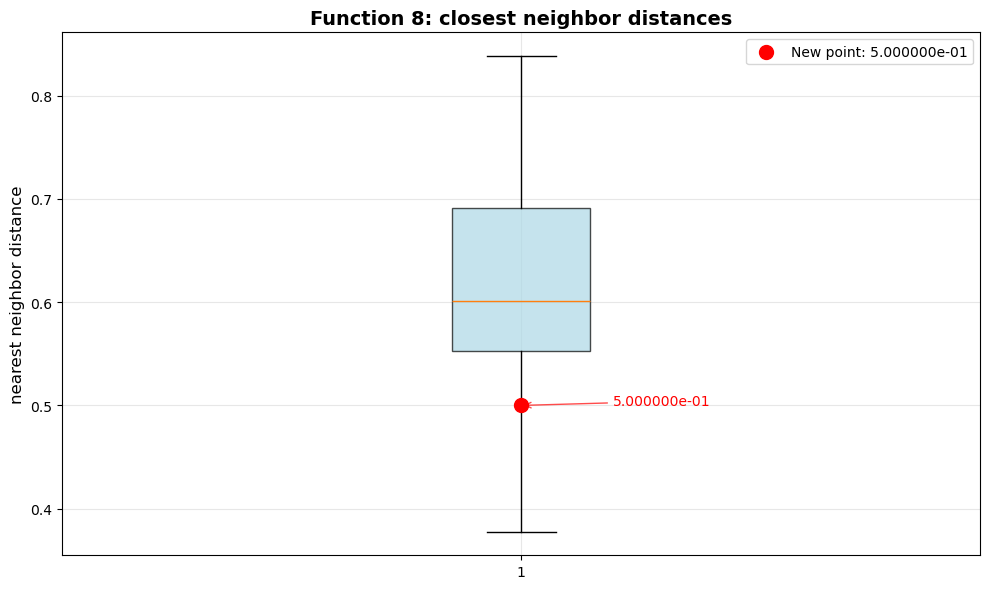

In [72]:
x8_distances = find_closest_neighbor_distances(np.array(x_8))
new_x8_distance = find_min_distance_to_array(x_new[7], np.array(x_8))
plot_boxplot_with_new_point(
    x8_distances, 
    new_x8_distance[0], 
    'Function 8: closest neighbor distances', 
    'nearest neighbor distance')

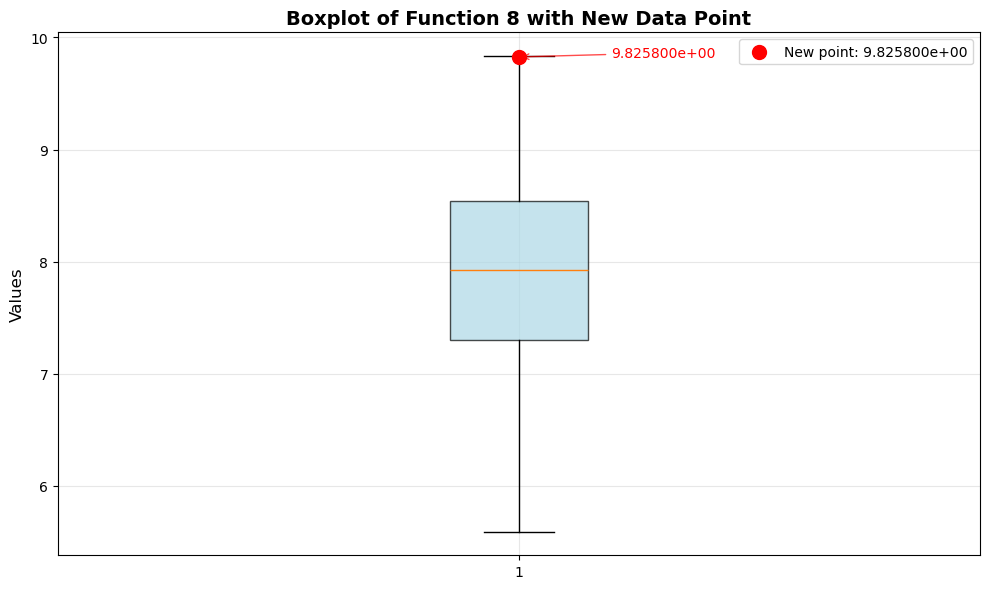

Old maximum: 9.833300e+00
New point: 9.825800e+00
Percentile rank in y_8: 97.6%

Old position: [0.25 0.25 0.   0.25 0.5  0.5  0.25 0.5 ]
New position: [0.   0.25 0.   0.25 0.75 0.5  0.   0.75]


In [79]:

plot_boxplot_with_new_point(
    y_8, 
    y_new[7], 
    'Boxplot of Function 8 with New Data Point', 
    'Values')

# Print some statistics for comparison
print(f"Old maximum: {np.max(y_8):.6e}")
print(f"New point: {y_new[7]:.6e}")
print(f"Percentile rank in y_8: {100 * (y_8 < y_new[7]).sum() / len(y_8):.1f}%")
print(f"\nOld position: {x_8[np.argmax(y_8)]}")
print(f"New position: {x_new[7]}")

# Add new data point

In [ ]:
x_1 = np.concatenate((x_1, x_new[0].reshape(1, -1)))
y_1 = np.concatenate((y_1, np.array([y_new[0]])))

x_2 = np.concatenate((x_2, x_new[1].reshape(1, -1)))
y_2 = np.concatenate((y_2, np.array([y_new[1]])))

x_3 = np.concatenate((x_3, x_new[2].reshape(1, -1)))
y_3 = np.concatenate((y_3, np.array([y_new[2]])))

x_4 = np.concatenate((x_4, x_new[3].reshape(1, -1)))
y_4 = np.concatenate((y_4, np.array([y_new[3]])))

x_5 = np.concatenate((x_5, x_new[4].reshape(1, -1)))
y_5 = np.concatenate((y_5, np.array([y_new[4]])))

x_6 = np.concatenate((x_6, x_new[5].reshape(1, -1)))
y_6 = np.concatenate((y_6, np.array([y_new[5]])))

x_7 = np.concatenate((x_7, x_new[6].reshape(1, -1)))
y_7 = np.concatenate((y_7, np.array([y_new[6]])))

x_8 = np.concatenate((x_8, x_new[7].reshape(1, -1)))
y_8 = np.concatenate((y_8, np.array([y_new[7]])))


# Find new query points

## Function 1

In [94]:
# Fit GP

# GP assumption
noise_assumption = 1e-10

# kernel parameters
length_scale = 0.01
nu = 1.5

# set up evaluation grid:
x_11 = np.linspace(0, 1, 100)
x_12 = np.linspace(0, 1, 100)
x_11, x_12 = np.meshgrid(x_11, x_12)
x_1_grid = np.column_stack([x_11.ravel(), x_12.ravel()])

# Define and fit GP
kernel = Matern(length_scale = length_scale, nu = nu)
model = GaussianProcessRegressor(kernel = kernel, alpha = noise_assumption, normalize_y=True)
model.fit(np.array(x_1), np.array(y_1))


# Get the predicted (posterior) mean and standard deviation for each grid point
post_mean, post_std = model.predict(x_1_grid, return_std = True)
print("average posterior mean:", mean(post_mean))
print("average posterior standard deviation:", mean(post_std))


average posterior mean: -0.000327815232549245
average posterior standard deviation: 0.0010351033560784709


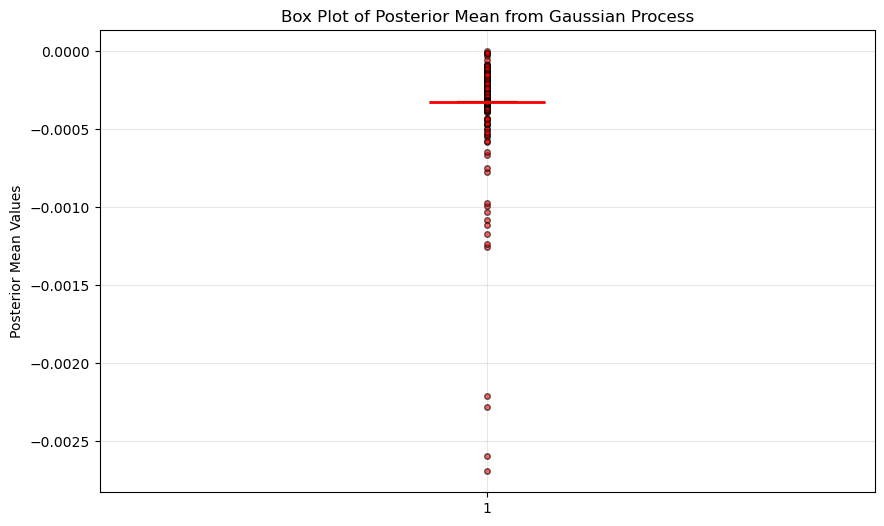

In [95]:
# Create density plot of post_mean
plot_boxplot(
    post_mean, 
    "Box Plot of Posterior Mean from Gaussian Process", 
    "Posterior Mean Values")

In [96]:
# Calculate acquisition function

# Calculate the UCB aquisition function
kappa =  1
UCB = post_mean + kappa * post_std

# Get the next query point
max_idx_1 = np.argmax(UCB)  
next_point_1 = x_1_grid[max_idx_1] 
print("Best known point:", x_1[np.argmax(y_1)])
print("Next query point:", round(next_point_1[0], 6), round(next_point_1[1], 6))

Best known point: [0.73102363 0.73299988]
Next query point: 0.787879 0.757576


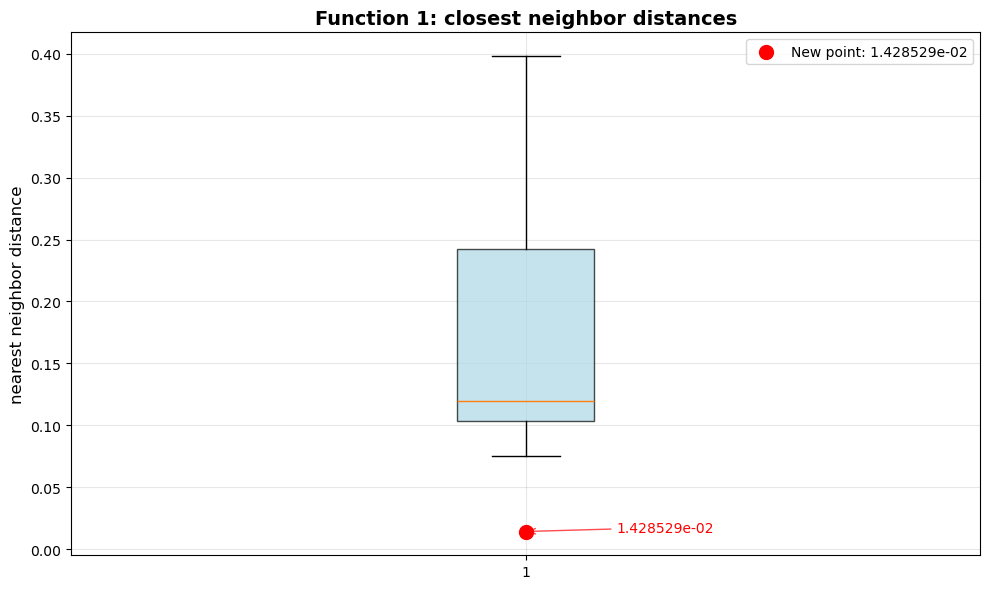

In [97]:
# check new distance compared to nearest neighbor distance
x1_distances = find_closest_neighbor_distances(np.array(x_1))
new_x1_distance = find_min_distance_to_array(next_point_1, np.array(x_1))
plot_boxplot_with_new_point(
    x1_distances, 
    new_x1_distance[0], 
    'Function 1: closest neighbor distances', 
    'nearest neighbor distance')

## Function 2

In [98]:
# GP assumption
noise_assumption = 1e-3

# kernel parameters
length_scale = 0.1

# set up evaluation grid:
x_21 = np.linspace(0, 1, 100)
x_22 = np.linspace(0, 1, 100)
x_21, x_22 = np.meshgrid(x_21, x_22)
x_2_grid = np.column_stack([x_21.ravel(), x_22.ravel()])

# Define and fit GP
kernel = RBF(length_scale = length_scale) 
model = GaussianProcessRegressor(kernel = kernel, alpha = noise_assumption, normalize_y=True)
model.fit(np.array(x_2), np.array(y_2))


# Get the predicted (posterior) mean and standard deviation for each grid point
post_mean, post_std = model.predict(x_2_grid, return_std = True)
print("average posterior mean:", mean(post_mean))
print("average posterior standard deviation:", mean(post_std))




average posterior mean: 0.20528713075047755
average posterior standard deviation: 0.1690993527477973


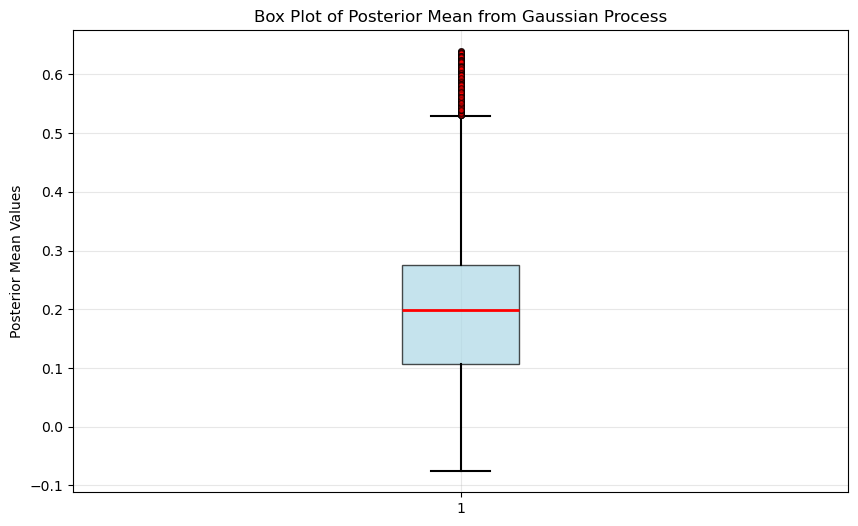

In [99]:
# Create density plot of post_mean
plot_boxplot(
    post_mean, 
    "Box Plot of Posterior Mean from Gaussian Process", 
    "Posterior Mean Values")

In [100]:
# Calculate the UCB aquisition function
kappa =  1 # choose this by looking at the mean post_mean and post_std to get an idea of the scale of each
UCB = post_mean + kappa * post_std

# Get the next query point
max_idx_2 = np.argmax(UCB)  
next_point_2 = x_2_grid[max_idx_2] 
print("Best known point:", x_2[np.argmax(y_2)])
print("Next query point:", round(next_point_2[0], 6), round(next_point_2[1], 6))

Best known point: [0.70263656 0.9265642 ]
Next query point: 0.787879 0.939394


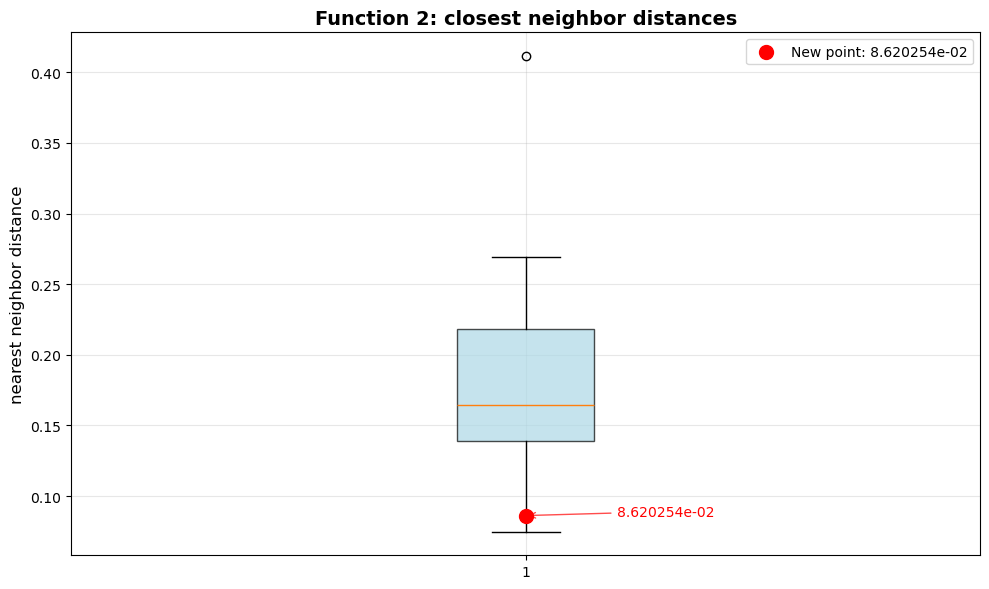

In [102]:
# check new distance compared to nearest neighbor distance
x2_distances = find_closest_neighbor_distances(np.array(x_2))
new_x1_distance = find_min_distance_to_array(next_point_2, np.array(x_2))
plot_boxplot_with_new_point(
    x2_distances, 
    new_x2_distance[0], 
    'Function 2: closest neighbor distances', 
    'nearest neighbor distance')

## Function 3

In [ ]:
# GP assumption
noise_assumption = 1e-10

# kernel parameters
length_scale = 0.1
nu = 1.5

# set up evaluation grid:
x_31 = np.linspace(0, 1, 100)
x_32 = np.linspace(0, 1, 100)
x_33 = np.linspace(0, 1, 100)
x_31, x_32, x_33 = np.meshgrid(x_31, x_32, x_33)
x_3_grid = np.column_stack([x_31.ravel(), x_32.ravel(), x_33.ravel()])

# Define and fit GP
#kernel = RBF(length_scale = length_scale) 
kernel = Matern(length_scale=length_scale, nu=nu) 
model = GaussianProcessRegressor(kernel = kernel, alpha = noise_assumption, normalize_y=True) 
model.fit(np.array(x_3), np.array(y_3))


# Get the predicted (posterior) mean and standard deviation for each grid point
post_mean, post_std = model.predict(x_3_grid, return_std = True)
print("average posterior mean:", mean(post_mean))
print("average posterior standard deviation:", mean(post_std))



In [ ]:
# Create density plot of post_mean
plot_boxplot(
    post_mean, 
    "Box Plot of Posterior Mean from Gaussian Process", 
    "Posterior Mean Values")

In [ ]:

# Calculate the UCB aquisition function
kappa =  1 
UCB = post_mean + kappa * post_std

# Get the next query point
max_idx_3 = np.argmax(UCB)  
next_point_3 = x_3_grid[max_idx_3] 
print("Best known point:", x_3[np.argmax(y_3)])
print("Next query point:", round(next_point_3[0], 6), round(next_point_3[1], 6), round(next_point_3[2], 6))


In [ ]:
# check new distance compared to nearest neighbor distance
x3_distances = find_closest_neighbor_distances(np.array(x_3))
new_x3_distance = find_min_distance_to_array(next_point_3, np.array(x_3))
plot_boxplot_with_new_point(
    x3_distances, 
    new_x3_distance[0], 
    'Function 3: closest neighbor distances', 
    'nearest neighbor distance')

## Function 4

In [ ]:
# GP assumption
noise_assumption = 1e-10

# kernel parameters
length_scale = 0.1
nu = 2.5

# set up evaluation grid:
x_41 = np.linspace(0, 1, 50)
x_42 = np.linspace(0, 1, 50)
x_43 = np.linspace(0, 1, 50)
x_44 = np.linspace(0, 1, 50)
x_41, x_42, x_43, x_44 = np.meshgrid(x_41, x_42, x_43, x_44)
x_4_grid = np.column_stack([x_41.ravel(), x_42.ravel(), x_43.ravel(), x_44.ravel()])

# Define and fit GP
kernel = Matern(length_scale=length_scale, nu=2.5)
model = GaussianProcessRegressor(kernel = kernel, alpha = noise_assumption, normalize_y=True) 
model.fit(np.array(x_4), np.array(y_4))


# Get the predicted (posterior) mean and standard deviation for each grid point
post_mean, post_std = model.predict(x_4_grid, return_std = True)
print("average posterior mean:", mean(post_mean))
print("average posterior standard deviation:", mean(post_std))




In [ ]:
# Create density plot of post_mean
plot_boxplot(
    post_mean, 
    "Box Plot of Posterior Mean from Gaussian Process", 
    "Posterior Mean Values")

In [ ]:

# Calculate the UCB aquisition function
kappa = 3 # choose this by looking at the mean post_mean and post_std to get an idea of the scale of each
UCB = post_mean + kappa * post_std


# Get the next query point
max_idx_4 = np.argmax(UCB)  
next_point_4 = x_4_grid[max_idx_4] 
print("Best known point:", x_4[np.argmax(y_4)])
print("Next query point:", round(next_point_4[0], 6), round(next_point_4[1], 6), round(next_point_4[2], 6), round(next_point_4[3], 6))


In [ ]:
# check new distance compared to nearest neighbor distance
x4_distances = find_closest_neighbor_distances(np.array(x_4))
new_x4_distance = find_min_distance_to_array(next_point_4, np.array(x_4))
plot_boxplot_with_new_point(
    x4_distances, 
    new_x4_distance[0], 
    'Function 4: closest neighbor distances', 
    'nearest neighbor distance')

## Function 5

In [ ]:

# GP assumption
noise_assumption = 1e-10

# kernel parameters
length_scale = 0.1

# set up evaluation grid:
x_51 = np.linspace(0, 1, 50)
x_52 = np.linspace(0, 1, 50)
x_53 = np.linspace(0, 1, 50)
x_54 = np.linspace(0, 1, 50)
x_51, x_52, x_53, x_54 = np.meshgrid(x_51, x_52, x_53, x_54)
x_5_grid = np.column_stack([x_51.ravel(), x_52.ravel(), x_53.ravel(), x_54.ravel()])

# Define and fit GP
kernel = RBF(length_scale = length_scale) 
model = GaussianProcessRegressor(kernel = kernel, alpha = noise_assumption, normalize_y=True) 
model.fit(np.array(x_5), np.array(y_5))


# Get the predicted (posterior) mean and standard deviation for each grid point
post_mean, post_std = model.predict(x_5_grid, return_std = True)
print("average posterior mean:", mean(post_mean))
print("average posterior standard deviation:", mean(post_std))




In [ ]:
# Create density plot of post_mean
plot_boxplot(
    post_mean, 
    "Box Plot of Posterior Mean from Gaussian Process", 
    "Posterior Mean Values")

In [ ]:
# Calculate the UCB aquisition function
kappa = 1 
UCB = post_mean + kappa * post_std


# Get the next query point
max_idx_5 = np.argmax(UCB)  
next_point_5 = x_5_grid[max_idx_5] 
print("Best known point:", x_5[np.argmax(y_5)])
print("Next query point:", round(next_point_5[0], 6), round(next_point_5[1], 6), round(next_point_5[2], 6), round(next_point_5[3], 6))

In [ ]:
# check new distance compared to nearest neighbor distance
x5_distances = find_closest_neighbor_distances(np.array(x_5))
new_x5_distance = find_min_distance_to_array(next_point_5, np.array(x_5))
plot_boxplot_with_new_point(
    x5_distances, 
    new_x5_distance[0], 
    'Function 5: closest neighbor distances', 
    'nearest neighbor distance')

## Function 6

In [ ]:
# GP assumption
noise_assumption = 1e-10

# kernel parameters
length_scale = 0.1

# set up evaluation grid:
x_61 = np.linspace(0, 1, 30)
x_62 = np.linspace(0, 1, 30)
x_63 = np.linspace(0, 1, 30)
x_64 = np.linspace(0, 1, 30)
x_65 = np.linspace(0, 1, 30)
x_61, x_62, x_63, x_64, x_65 = np.meshgrid(x_61, x_62, x_63, x_64, x_65)
x_6_grid = np.column_stack([x_61.ravel(), x_62.ravel(), x_63.ravel(), x_64.ravel(), x_65.ravel()])

# Define and fit GP
kernel = RBF(length_scale = length_scale) 
model = GaussianProcessRegressor(kernel = kernel, alpha = noise_assumption, normalize_y=True) 
model.fit(np.array(x_6), np.array(y_6))


# Get the predicted (posterior) mean and standard deviation for each grid point
post_mean, post_std = model.predict(x_6_grid, return_std = True)
print("average posterior mean:", mean(post_mean))
print("average posterior standard deviation:", mean(post_std))


In [ ]:
# Create density plot of post_mean
plot_boxplot(
    post_mean, 
    "Box Plot of Posterior Mean from Gaussian Process", 
    "Posterior Mean Values")

In [ ]:
# Calculate the UCB aquisition function
kappa = 1
UCB = post_mean + kappa * post_std

# Get the next query point
max_idx_6 = np.argmax(UCB)  
next_point_6 = x_6_grid[max_idx_6] 
print("Best known point:", x_6[np.argmax(y_6)])
print("Next query point:", round(next_point_6[0], 6), round(next_point_6[1], 6), round(next_point_6[2], 6), round(next_point_6[3], 6), round(next_point_6[4], 6))

In [ ]:
# check new distance compared to nearest neighbor distance
x6_distances = find_closest_neighbor_distances(np.array(x_6))
new_x6_distance = find_min_distance_to_array(next_point_6, np.array(x_6))
plot_boxplot_with_new_point(
    x6_distances, 
    new_x6_distance[0], 
    'Function 6: closest neighbor distances', 
    'nearest neighbor distance')

## Function 7

In [ ]:
# GP assumption
noise_assumption = 1e-10

# kernel parameters
length_scale = 0.1
nu = 1.5

# set up evaluation grid:
x_71 = np.linspace(0, 1, 15)
x_72 = np.linspace(0, 1, 15)
x_73 = np.linspace(0, 1, 15)
x_74 = np.linspace(0, 1, 15)
x_75 = np.linspace(0, 1, 15)
x_76 = np.linspace(0, 1, 15)
x_71, x_72, x_73, x_74, x_75, x_76 = np.meshgrid(x_71, x_72, x_73, x_74, x_75, x_76)
x_7_grid = np.column_stack([x_71.ravel(), x_72.ravel(), x_73.ravel(), x_74.ravel(), x_75.ravel(), x_76.ravel()])

# Define and fit GP
kernel = Matern(length_scale=length_scale, nu=nu) 
model = GaussianProcessRegressor(kernel = kernel, alpha = noise_assumption, normalize_y=True) 
model.fit(np.array(x_7), np.array(y_7))


# Get the predicted (posterior) mean and standard deviation for each grid point
post_mean, post_std = model.predict(x_7_grid, return_std = True)
print("average posterior mean:", mean(post_mean))
print("average posterior standard deviation:", mean(post_std))


In [ ]:
# Create density plot of post_mean
plot_boxplot(
    post_mean, 
    "Box Plot of Posterior Mean from Gaussian Process", 
    "Posterior Mean Values")

In [ ]:
# Calculate the UCB aquisition function
kappa = 1
UCB = post_mean + kappa * post_std

# Get the next query point
max_idx_7 = np.argmax(UCB)  
next_point_7 = x_7_grid[max_idx_7] 
print("Best known point:", x_7[np.argmax(y_7)])
print("Next query point:", round(next_point_7[0], 6), round(next_point_7[1], 6), round(next_point_7[2], 6), round(next_point_7[3], 6), round(next_point_7[4], 6), round(next_point_7[5], 6))

In [ ]:
# check new distance compared to nearest neighbor distance
x7_distances = find_closest_neighbor_distances(np.array(x_7))
new_x7_distance = find_min_distance_to_array(next_point_7, np.array(x_7))
plot_boxplot_with_new_point(
    x7_distances, 
    new_x7_distance[0], 
    'Function 7: closest neighbor distances', 
    'nearest neighbor distance')

## Function 8

In [ ]:

# GP assumption
noise_assumption = 1e-10

# kernel parameters
length_scale = 0.1
nu = 1.5

# set up evaluation grid:
x_81 = np.linspace(0, 1, 5)
x_82 = np.linspace(0, 1, 5)
x_83 = np.linspace(0, 1, 5)
x_84 = np.linspace(0, 1, 5)
x_85 = np.linspace(0, 1, 5)
x_86 = np.linspace(0, 1, 5)
x_87 = np.linspace(0, 1, 5)
x_88 = np.linspace(0, 1, 5)
x_81, x_82, x_83, x_84, x_85, x_86, x_87, x_88 = np.meshgrid(x_81, x_82, x_83, x_84, x_85, x_86, x_87, x_88)
x_8_grid = np.column_stack([x_81.ravel(), x_82.ravel(), x_83.ravel(), x_84.ravel(), x_85.ravel(), x_86.ravel(), x_87.ravel(), x_88.ravel()])

# Define and fit GP
kernel = Matern(length_scale=length_scale, nu=nu) 
model = GaussianProcessRegressor(kernel = kernel, alpha = noise_assumption, normalize_y=True) 
model.fit(np.array(x_8), np.array(y_8))


# Get the predicted (posterior) mean and standard deviation for each grid point
post_mean, post_std = model.predict(x_8_grid, return_std = True)
print("average posterior mean:", mean(post_mean))
print("average posterior standard deviation:", mean(post_std))


In [ ]:
# Create density plot of post_mean
plot_boxplot(
    post_mean, 
    "Box Plot of Posterior Mean from Gaussian Process", 
    "Posterior Mean Values")

In [ ]:
# Calculate the UCB aquisition function
kappa = 1
UCB = post_mean + kappa * post_std

# Get the next query point
max_idx_8 = np.argmax(UCB)  
next_point_8 = x_8_grid[max_idx_8] 
print("Best known point:", x_8[np.argmax(y_8)])
print("Next query point:", round(next_point_8[0], 6), round(next_point_8[1], 6), round(next_point_8[2], 6), round(next_point_8[3], 6), round(next_point_8[4], 6), round(next_point_8[5], 6), round(next_point_8[6], 6), round(next_point_8[7], 6))


In [ ]:
# check new distance compared to nearest neighbor distance
x8_distances = find_closest_neighbor_distances(np.array(x_8))
new_x8_distance = find_min_distance_to_array(next_point_8, np.array(x_8))
plot_boxplot_with_new_point(
    x8_distances, 
    new_x8_distance[0], 
    'Function 8: closest neighbor distances', 
    'nearest neighbor distance')